# Interpretability Tests and Experiments

Going to do some prelim tests to show case mech interp techniques, mathematical unpinnings of said techniques and how it applies to the larger project.

This notebook serves as the proof-of-concept for the "Researcher Layer" of Clear-box AI web app. 
It validates the mathematical operations required for:
1. **Signal Extraction:** Capturing hidden states and attentions.
2. **Logit Attribution:** Understanding next-token prediction via the Logit Lens.
3. **Concept Visualization:** PCA projection of the residual stream.

**Model:** GPT-2 (Small)
**Goal:** Validate logic before porting to TypeScript/WebGPU.

In [1]:
# imports
import torch
import torch.nn.functional as F 
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/mnt/c/Users/Mahmoud Shabana/Documents/software_projects/clearbox_ai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

Running on: cuda


### Engine Layer:

This corresponds to the `src/engine/ModelManager.ts`.
We use standard HuggingFace, but we explicitly request `output_hidden_states` and `output_attentions`.

In [ ]:
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# silly config thing that needs to be set for attention dumps, GPT2 defaults to using SDPA which don't preserve full attention matrices
# could be the same issue we are seeing in the js implementation!
model.config._attn_implementation = "eager" 

model.config.output_attentions=True # testing attention extraction prior to forward pass
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
def run_inference(prompt: str):
    """
    Run inference and capture internals.
    Equivalent to the Web Worker's `generate` func with full observability.
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(
            **inputs,
            output_hidden_states=True # ref for this on HF: https://huggingface.co/docs/transformers/v4.26.0/main_classes/output#transformers.modeling_outputs.BaseModelOutput.hidden_states
        )
    
    # hidden_states: Tuple of (layer_count + 1) tensors. Shape: [batch, seq, hidden]
    # attentions: Tuple of (layer_count) tensors. Shape: [batch, heads, seq, seq]
    # logits: Shape [batch, seq, vocab]
    if outputs.attentions:
        print(f"Attentions available, number of layers: {len(outputs.attentions)}")
    else:
        print("Attentions are still empty :(")

    return {
        "input_ids": inputs["input_ids"],
        "tokens": [tokenizer.decode([t]) for t in inputs["input_ids"][0]],
        "hidden_states": outputs.hidden_states,
        "attentions": outputs.attentions,
        "logits": outputs.logits
    }

In [31]:
# quick test run of inference func
prompt = "The Eiffel Tower is located in the city of"
data = run_inference(prompt)
print(f"Prompt tokens: {data['tokens']}")
print(f"Total layers captured: {len(data['hidden_states'])}") # should be 13 => Embed + 12 blocks

Attentions available, number of layers: 12
(tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.6396e-01, 1.3604e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.8329e-01, 1.8007e-01, 3.6641e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.2540e-01, 1.0716e-01, 1.2799e-01,  ..., 3.2029e-02,
           0.0000e+00, 0.0000e+00],
          [2.7810e-01, 1.2472e-01, 1.0933e-01,  ..., 7.5133e-02,
           5.7230e-02, 0.0000e+00],
          [2.7703e-01, 1.2504e-01, 9.5384e-02,  ..., 5.0563e-02,
           6.3861e-02, 3.1175e-02]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.7979e-04, 9.9912e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.8893e-05, 5.6890e-04, 9.9940e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.24

## Logit Attribution

This technique applies the Unembedding Matrix ($W_U$) to the hidden state of *intermediate* layers. It answers: "If we stopped the model at Layer $L$, what token would it predict?"

Mathematical Logic: $ Logits_L = h_L \cdot W_U^T $

This validates the logic for `src/vis/LogitDistribution.tsx`.

In [6]:
def logit_lens(hidden_states, model, tokenizer, top_k=5):
    """
    Apply language model head to every layer's hidden state.
    """
    unembed_matrix = model.lm_head.weight # shape: [vocab, hidden]
    # print(f"Vocab: {unembed_matrix[0]}\nHidden: {unembed_matrix[1]}")
    layer_preds = []

    for layer_idx, hidden in enumerate(hidden_states):
        # the hidden shape = [1, seq_len, 768]
        # only interested in the prediction at the last token pos
        last_hidden_token = hidden[0, -1, :] # shape: [768]

        # Project to vocab space
        # In the standard GPT-2, LayerNorm(ln_f) is applied before the head.
        # The strict logit lens usually bypasses ln_f for raw stream analysis
        # but for prediction parity, we should ideally apply it at the final layer.
        # We'll do a direct projection for raw residual stream analysis.
        logits = torch.matmul(unembed_matrix, last_hidden_token)
        probs = F.softmax(logits, dim=-1)
        top_probs, top_idxs = torch.topk(probs, top_k)

        preds = []
        for rank, (prob, idx) in enumerate(zip(top_probs, top_idxs)):
            token = tokenizer.decode([idx.item()])
            preds.append(f"{token} ({prob:.2f})")
        layer_preds.append(preds)
    
    return layer_preds


In [7]:
# execute logit lens
predictions = logit_lens(data["hidden_states"], model, tokenizer)

print(f"Target completion expected: ' Paris'\n")
for i, preds in enumerate(predictions):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

Target completion expected: ' Paris'

Embed      | Top 5 prediction:  of (0.00),of (0.00),- (0.00),, (0.00), in (0.00)
Layer 0    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), an (0.00)
Layer 1    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), an (0.00), ' (0.00)
Layer 2    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), an (0.00)
Layer 3    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), D (0.00)
Layer 4    | Top 5 prediction:  the (1.00), a (0.00),sp (0.00), G (0.00), D (0.00)
Layer 5    | Top 5 prediction:  the (1.00),, (0.00), G (0.00), D (0.00), B (0.00)
Layer 6    | Top 5 prediction:  the (1.00),, (0.00), G (0.00), D (0.00), B (0.00)
Layer 7    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), G (0.00), M (0.00)
Layer 8    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), a (0.00), T (0.00)
Layer 9    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), New (0.00), a (0.00)
Layer 10   | Top 5 prediction:  the (1.00),, (0.00)

It's interesting to see how low the probability for the predicted token ' Paris' is for this prompt. How can we try to force the probability for this specifc token to be higher with our current prompt? 

Maybe just giving more "french" nouns? Let's try it:

In [8]:
prompt_2 = "The Eiffel Tower and croissants are located in the city of"
data_run_2 = run_inference(prompt_2)
print(f"Prompt tokens: {data_run_2['tokens']}")

prompt_3 = "The Eiffel Tower and croissants and louis vuitton are located in the city of"
data_run_3 = run_inference(prompt_3)
print(f"Prompt tokens: {data_run_3['tokens']}")

prompt_4 = "The Eiffel Tower, croissants, and louis vuitton are located in the city of"
data_run_4 = run_inference(prompt_4)
print(f"Prompt tokens: {data_run_4['tokens']}")

Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ' and', ' cro', 'iss', 'ants', ' are', ' located', ' in', ' the', ' city', ' of']
Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ' and', ' cro', 'iss', 'ants', ' and', ' lou', 'is', ' v', 'u', 'itton', ' are', ' located', ' in', ' the', ' city', ' of']
Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ',', ' cro', 'iss', 'ants', ',', ' and', ' lou', 'is', ' v', 'u', 'itton', ' are', ' located', ' in', ' the', ' city', ' of']


In [9]:
# execute context influence
predictions_2 = logit_lens(data_run_2["hidden_states"], model, tokenizer)
predictions_3 = logit_lens(data_run_3["hidden_states"], model, tokenizer)
predictions_4 = logit_lens(data_run_4["hidden_states"], model, tokenizer)

print(f"Target completion expected: ' Paris'\n")

print(f"Original Prompt: {prompt} (0.06)")

print(f"\nPrompt 2: {prompt_2}")
for i, preds in enumerate(predictions_2):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

print(f"\nPrompt 3: {prompt_3}")
for i, preds in enumerate(predictions_3):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

print(f"\nPrompt 4: {prompt_4}")
for i, preds in enumerate(predictions_4):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

Target completion expected: ' Paris'

Original Prompt: The Eiffel Tower is located in the city of (0.06)

Prompt 2: The Eiffel Tower and croissants are located in the city of
Embed      | Top 5 prediction:  of (0.00),of (0.00),, (0.00),- (0.00), in (0.00)
Layer 0    | Top 5 prediction:  the (1.00), a (0.00), " (0.00),, (0.00), ' (0.00)
Layer 1    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), an (0.00), ' (0.00)
Layer 2    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), an (0.00)
Layer 3    | Top 5 prediction:  the (1.00), a (0.00), " (0.00),, (0.00), D (0.00)
Layer 4    | Top 5 prediction:  the (1.00), a (0.00),sp (0.00), G (0.00), D (0.00)
Layer 5    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), G (0.00), a (0.00)
Layer 6    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), G (0.00), a (0.00)
Layer 7    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), a (0.00), G (0.00)
Layer 8    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), a (0.00), " (0.00)
L

## Attention Visualization

We extract the attention pattern $A^h$ for a specific head $h$ in layer $l$.

$$ A^h = \text{softmax}(\frac{QK^T}{\sqrt{d_k}}) $$

In [32]:
def plot_attention_head(attentions, tokens, layer_idx, head_idx):
    """
    Visualizes attention weights for a specific head.
    """
    # grab layer at idx
    layer_attn = attentions[layer_idx] # [batch, heads, seq, seq]

    # grab attn at idx
    head_attn = layer_attn[0, head_idx, :, :].cpu().numpy() # [seq, seq]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        head_attn,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis",
        square=True,
        annot=False # hide raw prob values
    )
    plt.title(f"Attention: Layer {layer_idx}, Head {head_idx}")
    plt.xlabel("Key (Source Token)")
    plt.xlabel("Query (Destination Token)")
    plt.show()


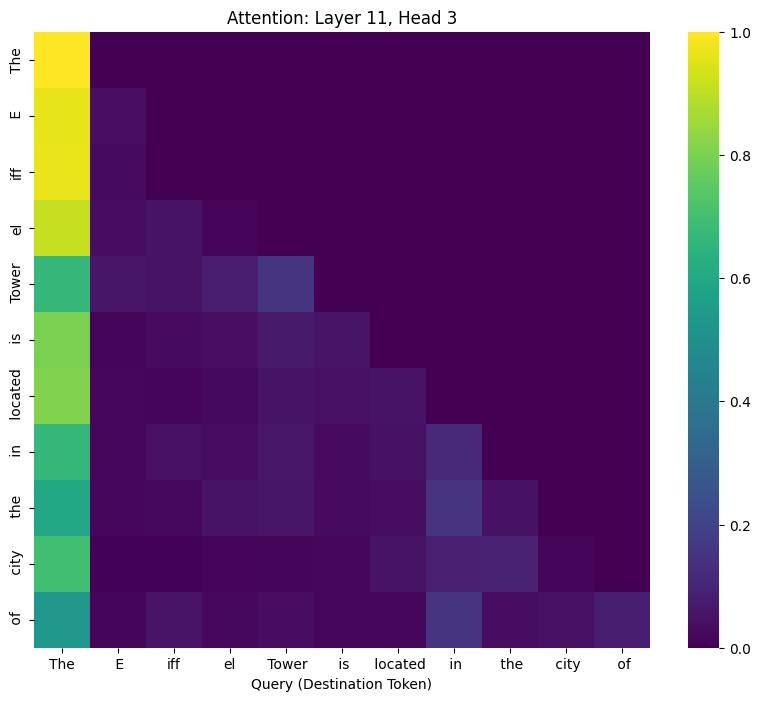

In [39]:
# testing a visual on layer 5, head 1
plot_attention_head(data['attentions'], data['tokens'], layer_idx=11, head_idx=3)